In [1]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/niubuzhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/niubuzhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

In [3]:
from bs4 import BeautifulSoup

In [4]:
from project_helper import *

In [5]:
sec_api = SecAPI()
def get_sec_data(cik, doc_type, start = 0, count = 60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    return [ (
        entry.content.find('filing-href').getText(),
        entry.content.find('filing-type').getText(),
        entry.content.find('filing-date').getText()
    ) for entry in feed.find_all('entry', recursive = False)]

In [6]:
import pprint

In [7]:
sec_data = {}
for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')
ticker_example = 'AMZN'
pprint.pprint(sec_data[ticker_example][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872420000004/0001018724-20-000004-index.htm',
  '10-K',
  '2020-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/0001018724-19-000004-index.htm',
  '10-K',
  '2019-02-01'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872418000005/0001018724-18-000005-index.htm',
  '10-K',
  '2018-02-02'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29')]


In [8]:
from tqdm import tqdm

In [9]:
raw_filings_by_ticker = {}
for ticker, data in sec_data.items():
    raw_filings_by_ticker[ticker] = {}
    for index_ref, file_type, file_date in tqdm(data, desc = 'Downloading {} filings:'.format(ticker), unit = 'filings'):
        if file_type == '10-K':
            valid_url = index_ref.replace('-index.htm', '.txt').replace('.txtl', '.txt')
            raw_filings_by_ticker[ticker][file_date] = sec_api.get(valid_url)

In [10]:
print(next(iter(raw_filings_by_ticker[ticker_example].values()))[:1000])

<SEC-DOCUMENT>0001018724-20-000004.txt : 20200131
<SEC-HEADER>0001018724-20-000004.hdr.sgml : 20200131
<ACCEPTANCE-DATETIME>20200130204613
ACCESSION NUMBER:		0001018724-20-000004
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		109
CONFORMED PERIOD OF REPORT:	20191231
FILED AS OF DATE:		20200131
DATE AS OF CHANGE:		20200130

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		20562951

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<SEQUENCE>1
<FILENAM

In [11]:
import re

In [12]:
def get_documents(text):
    extracted_docs = []
    
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    
    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
        extracted_docs.append(text[doc_start_i:doc_end_i])
        
    return extracted_docs

In [13]:
filings_documents_by_ticker = {}
for ticker, data in raw_filings_by_ticker.items():
    filings_documents_by_ticker[ticker] = {}
    for date, txt in tqdm(data.items(), desc = 'Getting docs for ticker {}'.format(ticker), unit = 'filing'):
        filings_documents_by_ticker[ticker][date] = get_documents(txt)

Getting docs for ticker HON: 100%|██████████| 23/23 [00:00<00:00, 54.16filing/s]


In [14]:
print('\n\n'.join(['Document {} filed on {}: \n {}'.format(doc_i, date, docTxt[:200]) for date, docs in filings_documents_by_ticker[ticker_example].items() for doc_i, docTxt in enumerate(docs)][:3]))

Document 0 filed on 2020-01-31: 
 
<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20191231x10k.htm
<DESCRIPTION>10-K
<TEXT>
<XBRL>
<?xml version="1.0" encoding="UTF-8"?>
<!--XBRL Document Created with Wdesk from Workiva-->
<!--p:c57a17684e854b

Document 1 filed on 2020-01-31: 
 
<TYPE>EX-4.6
<SEQUENCE>2
<FILENAME>amzn-20191231xex46.htm
<DESCRIPTION>EXHIBIT 4.6
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>

Document 2 filed on 2020-01-31: 
 
<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20191231xex211.htm
<DESCRIPTION>EXHIBIT 21.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht


In [15]:
def get_document_type(doc):
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    doc_type = type_pattern.findall(doc)[0][len('<TYPE>'):]
    return doc_type.lower()

In [16]:
ten_ks_by_ticker = {}
for ticker, filingData in filings_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for filingDate, docs in filingData.items():
        for doc in docs:
            if get_document_type(doc) == '10-k':
                ten_ks_by_ticker[ticker].append(
                {
                    'cik': cik_lookup[ticker],
                    'file': doc,
                    'filing_date': filingDate
                }
                )

In [17]:
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def clean_text(text):
    return remove_html_tags(text.lower())

In [18]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc = 'Cleaning 10-K data for ticker {}'.format(ticker), unit = '10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])

Cleaning 10-K data for ticker HON: 100%|██████████| 23/23 [00:45<00:00,  2.00s/10-K]


In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [20]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [ lemmatizer.lemmatize(word, 'v') for word in words]

In [21]:
word_pattern = re.compile('\w+')

In [22]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc = 'Lemmatize {} 10-k'.format(ticker), unit = '10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

Lemmatize HON 10-k: 100%|██████████| 23/23 [00:03<00:00,  7.3910-K/s]


In [23]:
from multiprocessing import Pool, cpu_count

In [24]:
cpu_count()

4

In [25]:
from nltk.corpus import stopwords
lemma_stop_english = lemmatize_words(stopwords.words('english'))

In [26]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc = 'Remove stop words for ticker {}'.format(ticker), unit = '10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_stop_english]

Remove stop words for ticker HON: 100%|██████████| 23/23 [00:01<00:00, 15.6210-K/s]


### Now introducing sentiments and analyze term frequency in docs

In [27]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']
import pandas
sentiment_df = pandas.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')

In [28]:
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df.drop_duplicates('word', inplace = True)

sentiment_df.head(3)

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments


In [29]:
sentiment_df[sentiment_df.uncertainty].tail(1)

,negative,positive,uncertainty,litigious,constraining,interesting,word
83671,True,False,True,False,False,False,volatility


In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
import numpy as np

In [32]:
def get_bag_of_words(sentiment_words, docs):
    
    vec = CountVectorizer(vocabulary = sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]
    
    return bag_of_words.astype(int)

In [33]:
sentiment_bow_ten_ks = {}

In [34]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs) for sentiment in sentiments}

In [35]:
from sklearn.metrics import jaccard_similarity_score

In [36]:
def get_jaccard_similarity(bag_of_words_matrix):
    jaccard_similarities = []
    bag_of_words = np.array(bag_of_words_matrix, dtype = bool)
    
    for i in range(len(bag_of_words) - 1):
        u = bag_of_words[i]
        v = bag_of_words[i+1]
        
        jaccard_similarities.append(jaccard_similarity_score(u, v))
        
    return jaccard_similarities

In [37]:
file_dates = {ticker : [ten_k['filing_date'] for ten_k in ten_ks] for ticker, ten_ks in ten_ks_by_ticker.items()}

In [38]:
jaccard_similarities = {ticker : {
    sentiment: get_jaccard_similarity(bag_of_words) for sentiment, bag_of_words in ticker_sentiment.items()
} for ticker, ticker_sentiment in sentiment_bow_ten_ks.items()}

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


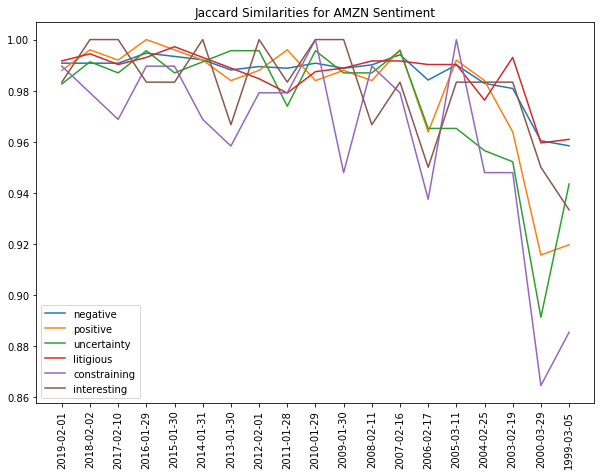

In [39]:
plot_similarities([jaccard_similarities[ticker_example][sentiment] for sentiment in sentiments], file_dates[ticker_example][1:], 'Jaccard Similarities for {} Sentiment'.format(ticker_example), sentiments)

### Introducing Term Frequency * Inverse Document Frequency

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
def get_tfidf(sentiment_words, docs):
    vec = TfidfVectorizer(vocabulary = sentiment_words)
    return vec.fit_transform(docs).toarray()

In [42]:
sentiment_tfidf_ten_ks = {}
for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs) for sentiment in sentiments
    }

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
def get_cosine_similarity(tfidf_matrix):
    cosine_similarities = []
    for i in range(len(tfidf_matrix) - 1):
        cosine_similarities.append(
            cosine_similarity(tfidf_matrix[i].reshape(1,-1), tfidf_matrix[i+1].reshape(1, -1))[0, 0]
        )
    return cosine_similarities

In [45]:
cosine_similarities = {
    ticker : {
        sentiment : get_cosine_similarity(tfidf_matrix)
        for sentiment, tfidf_matrix in sentiment_values.items()
    } for ticker, sentiment_values in sentiment_tfidf_ten_ks.items()
}

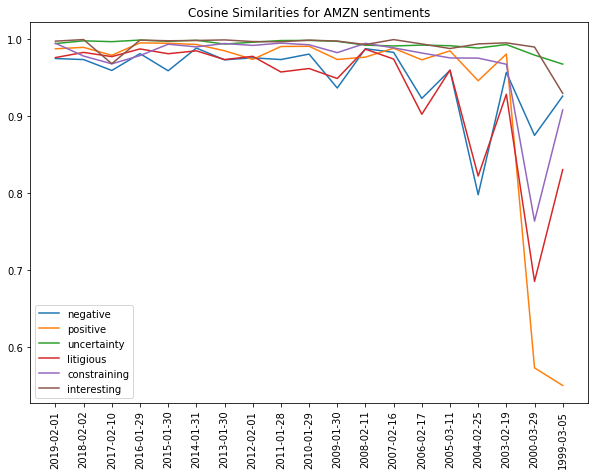

In [47]:
plot_similarities(
    [cosine_similarities[ticker_example][sentiment] for sentiment in sentiments],
    file_dates[ticker_example][1:],
    "Cosine Similarities for {} sentiments".format(ticker_example),
    sentiments,
)

In [48]:
from itertools import chain
lis = list(chain.from_iterable(file_dates.values()))
print(max(lis))
print(min(lis))

2020-03-27
1994-03-18


In [69]:
pricing = pandas.read_csv(r'/home/niubuzhi/Documents/ml/nlp/10-k/daily_yahoo_finance.csv', parse_dates = ['date'])

In [70]:
pricing.head(2)

,date,adj_close,ticker
0,1997-05-15,1.958333,AMZN
1,1997-05-16,1.729167,AMZN


In [71]:
pricing = pricing.pivot(index = 'date', columns = 'ticker', values = 'adj_close')

In [72]:
pricing.head()

ticker,AMZN,BMY,CNP,CVX,FL,FRT,HON
date,,,,,,,
1994-03-18,NaN,3.137510,2.311723,6.385364,12.135096,7.547022,9.702696
1994-03-21,NaN,3.173909,2.296259,6.256280,12.058779,7.276553,9.734197
1994-03-22,NaN,3.093833,2.273065,6.256280,12.058779,7.413850,9.765699
1994-03-23,NaN,3.093833,2.280797,6.264884,11.982451,7.413850,9.860203
1994-03-24,NaN,3.013758,2.242139,6.239072,11.829809,7.482497,9.797200


In [125]:
import datetime
dayOffset = pandas.tseries.offsets.BusinessDay(n = 1)
cosine_similarity_df_dict = {'date' : [], 'ticker' : [], 'sentiment' : [], 'value' : []}
for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment, sentiment_values in ten_k_sentiments.items():
        for inx, sentiment_value in enumerate(sentiment_values):
            cosine_similarity_df_dict['ticker'].append(ticker)
            cosine_similarity_df_dict['sentiment'].append(sentiment)
            cosine_similarity_df_dict['value'].append(sentiment_value)
            cosine_similarity_df_dict['date'].append(file_dates[ticker][1:][inx])
cosine_similarity_df = pandas.DataFrame(cosine_similarity_df_dict)
cosine_similarity_df['date'] = pandas.DatetimeIndex(cosine_similarity_df['date']).year
cosine_similarity_df['date'] = pandas.to_datetime(cosine_similarity_df['date'], format = '%Y')
cosine_similarity_df['date'] = cosine_similarity_df['date'].apply(lambda x: (x + dayOffset))
cosine_similarity_df.head(5)

,date,ticker,sentiment,value
0,2019-01-02,AMZN,negative,0.974958
1,2018-01-02,AMZN,negative,0.973553
2,2017-01-02,AMZN,negative,0.959390
3,2016-01-04,AMZN,negative,0.981287
4,2015-01-02,AMZN,negative,0.959012


In [126]:
import alphalens as al

In [127]:
def get_csv(ticker):
    url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1=763948800&period2=1585267200&interval=1d&events=history".format(ticker)
    df = pandas.read_csv(url, usecols = [0, 5])
    df['ticker'] = [ticker] * len(df)
    return df.rename(columns = {'Date':'date', 'Adj Close':'adj_close'})
#df_all_pricing = pandas.concat([get_csv(ticker) for ticker in cik_lookup.keys()], ignore_index = True)
#df_all_pricing.to_csv(r'/home/niubuzhi/Documents/ml/nlp/10-k/daily_yahoo_finance.csv', index = False)

In [128]:
factor_data = {}
skipped_sentiments = []
for sentiment in sentiments:
    cs_df = cosine_similarity_df[cosine_similarity_df.sentiment == sentiment]
    cs_df = cs_df.pivot(index = 'date', columns = 'ticker', values = 'value')
    
    try:
        factor_data[sentiment] = al.utils.get_clean_factor_and_forward_returns(cs_df.stack(), pricing.loc[cs_df.index], quantiles = 5, bins = None, periods = [1])
    except:
        skipped_sentiments.append(sentiment)
        
if skipped_sentiments:
    print('\n Skipped the following sentiments: \n {}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()

/home/niubuzhi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Dropped 9.0% entries from factor data: 9.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.0% entries from factor data: 9.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.0% entries from factor data: 9.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.0% entries from factor data: 9.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.0% entries from factor data: 9.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.0% en

1D    factor  factor_quantile
date       asset                                     
1996-01-02 BMY    0.535156  0.906524                5
           CVX    0.336387  0.714728                2
           FRT    0.246014  0.616643                1
           HON    0.408270  0.775785                4
1997-01-02 BMY    0.841381  0.906282                5

### Factor returns

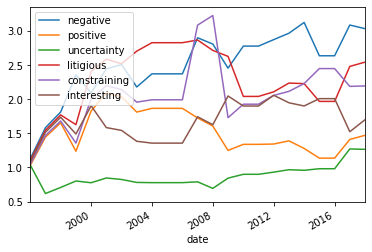

In [129]:
ls_factor_returns = pandas.DataFrame()
for factor, data in factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(data).iloc[:, 0]
    
(1+ls_factor_returns).cumprod().plot()

### Quantile returns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e1f337fd0>,
      dtype=object)

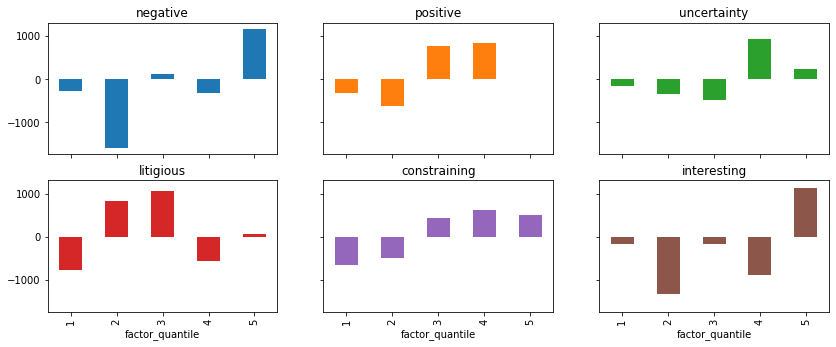

In [130]:
qr_factor_returns = pandas.DataFrame()

for factor_name, data in factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]
    
(1e4 * qr_factor_returns).plot.bar(
    subplots = True,
    sharey = True,
    layout = (5,3),
    figsize = (14,14),
    legend = False
)

In [131]:
annulization_factor = np.sqrt(252)
(annulization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

negative        6.62
positive        2.75
uncertainty     2.37
litigious       5.27
constraining    4.20
interesting     3.46
dtype: float64